In [6]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Load the data
df = pd.read_csv('cci_programs_data_reduced.csv', low_memory=False)

# Rename columns
df = df.rename(columns={
    'Agency Name': 'Agency_Name',
    'County': 'County'
})

# Convert relevant fields to numeric
df['Total Program GGRFFunding'] = pd.to_numeric(df['Total Program GGRFFunding'], errors='coerce')
df['Total Project GHGReductions'] = pd.to_numeric(df['Total Project GHGReductions'], errors='coerce')
df['Total GGRFDisadvantaged Community Funding'] = pd.to_numeric(
    df['Total GGRFDisadvantaged Community Funding'], errors='coerce')

# Filter valid projects
df = df[df['Total Project GHGReductions'] > 0].copy()

# Derived variables
df['cost_per_ton'] = df['Total Program GGRFFunding'] / df['Total Project GHGReductions']
df['share_DAC'] = df['Total GGRFDisadvantaged Community Funding'] / df['Total Program GGRFFunding']
df['log_funding'] = np.log1p(df['Total Program GGRFFunding'])

# Collapse agencies
top_agencies = df['Agency_Name'].value_counts().nlargest(5).index
df['Agency_Collapsed'] = df['Agency_Name'].where(df['Agency_Name'].isin(top_agencies), 'Other')

# --- MODEL 1: GHG Reduction Efficiency (No Year) ---
model_df = df[['cost_per_ton', 'log_funding', 'Agency_Collapsed']].dropna()
panel_model_no_year = smf.ols('cost_per_ton ~ log_funding + C(Agency_Collapsed)', data=model_df).fit(cov_type='HC3')
print(panel_model_no_year.summary())

# --- MODEL 2: Equity Outcome (No Year) ---
equity_df = df[['share_DAC', 'log_funding', 'Agency_Collapsed']].dropna()
equity_model_no_year = smf.ols('share_DAC ~ log_funding + C(Agency_Collapsed)', data=equity_df).fit(cov_type='HC3')
print(equity_model_no_year.summary())



                            OLS Regression Results                            
Dep. Variable:           cost_per_ton   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     161.4
Date:                Mon, 05 May 2025   Prob (F-statistic):          3.45e-205
Time:                        15:03:46   Log-Likelihood:            -1.4572e+06
No. Observations:              135433   AIC:                         2.914e+06
Df Residuals:                  135426   BIC:                         2.914e+06
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

In [7]:
df['Year'] = df['Reporting Cycle Name'].str.extract(r'(20\d{2})').astype(float)

df.groupby('Year')['cost_per_ton'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(2)

# print as md table
def print_md_table(df):
    print(df.to_markdown(index=True, floatfmt=".2f"))
print_md_table(df.groupby('Year')['cost_per_ton'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(2))



|    Year |    count |    mean |   median |      std |   min |        max |
|--------:|---------:|--------:|---------:|---------:|------:|-----------:|
| 2015.00 | 15974.00 |  340.25 |   308.82 |   641.02 |  0.00 |   50000.00 |
| 2016.00 | 11521.00 |  529.28 |   310.34 |  3864.96 |  0.00 |  264967.67 |
| 2017.00 | 14761.00 |  577.60 |   312.50 |  7806.06 |  0.00 |  910800.00 |
| 2018.00 | 21703.00 |  669.61 |   312.50 |  3706.63 |  0.00 |  250078.00 |
| 2019.00 | 16322.00 | 1332.69 |   365.38 |  6918.01 |  0.50 |  370000.00 |
| 2020.00 | 17091.00 | 1374.72 |   281.25 | 26436.15 |  0.22 | 3328131.00 |
| 2021.00 | 13798.00 | 1427.57 |   500.00 | 10209.97 |  0.50 |  998857.00 |
| 2022.00 | 12139.00 | 1209.64 |   500.00 |  6685.17 |  0.58 |  448437.77 |
| 2023.00 |  9094.00 | 2567.37 |   937.50 | 13737.46 |  0.00 |  852800.00 |
| 2024.00 |  3030.00 | 2389.72 |   937.50 |  7350.81 |  4.29 |  150000.00 |


|    Year |    count |    mean |   median |      std |   min |        max |
|--------:|---------:|--------:|---------:|---------:|------:|-----------:|
| 2015.00 | 15974.00 |  340.25 |   308.82 |   641.02 |  0.00 |   50000.00 |
| 2016.00 | 11521.00 |  529.28 |   310.34 |  3864.96 |  0.00 |  264967.67 |
| 2017.00 | 14761.00 |  577.60 |   312.50 |  7806.06 |  0.00 |  910800.00 |
| 2018.00 | 21703.00 |  669.61 |   312.50 |  3706.63 |  0.00 |  250078.00 |
| 2019.00 | 16322.00 | 1332.69 |   365.38 |  6918.01 |  0.50 |  370000.00 |
| 2020.00 | 17091.00 | 1374.72 |   281.25 | 26436.15 |  0.22 | 3328131.00 |
| 2021.00 | 13798.00 | 1427.57 |   500.00 | 10209.97 |  0.50 |  998857.00 |
| 2022.00 | 12139.00 | 1209.64 |   500.00 |  6685.17 |  0.58 |  448437.77 |
| 2023.00 |  9094.00 | 2567.37 |   937.50 | 13737.46 |  0.00 |  852800.00 |
| 2024.00 |  3030.00 | 2389.72 |   937.50 |  7350.81 |  4.29 |  150000.00 |

Max 2020 is "On the 27 Bryant route from Cyril Magnin (5th Street)/Market to Jackson/Van Ness, the type of work includes 8 transit bulbs, 2 pedestrian bulbs, and 2 signal timing upgrades. Pedestrian improvements including daylighting, curb ramps and crosswalk upgrades are proposed for 8 intersections. Improvements will reduce travel times and improve reliability for Muni riders."

Correlation between mean and median: 0.90


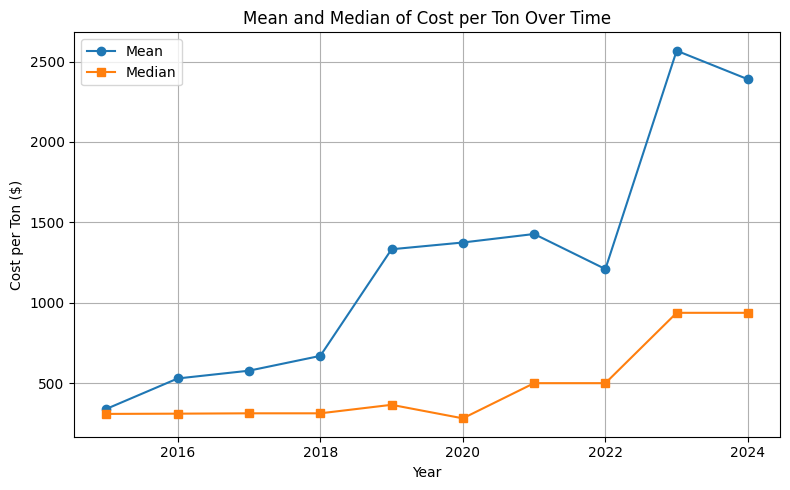

In [8]:
import matplotlib.pyplot as plt

# Group by year and calculate mean and median
stats = df.groupby('Year')['cost_per_ton'].agg(['mean', 'median']).dropna()

# Calculate the correlation coefficient
correlation = stats['mean'].corr(stats['median'])
print(f"Correlation between mean and median: {correlation:.2f}")

# Plot mean vs. median over time
plt.figure(figsize=(8, 5))
plt.plot(stats.index, stats['mean'], label='Mean', marker='o')
plt.plot(stats.index, stats['median'], label='Median', marker='s')
plt.title('Mean and Median of Cost per Ton Over Time')
plt.xlabel('Year')
plt.ylabel('Cost per Ton ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

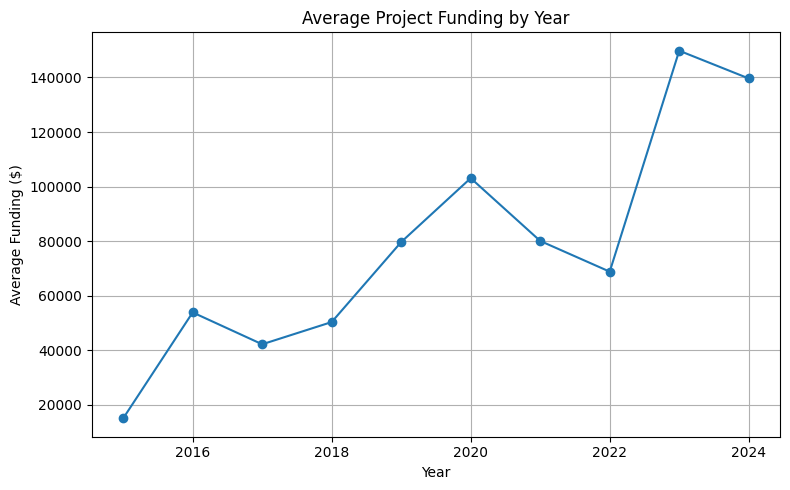

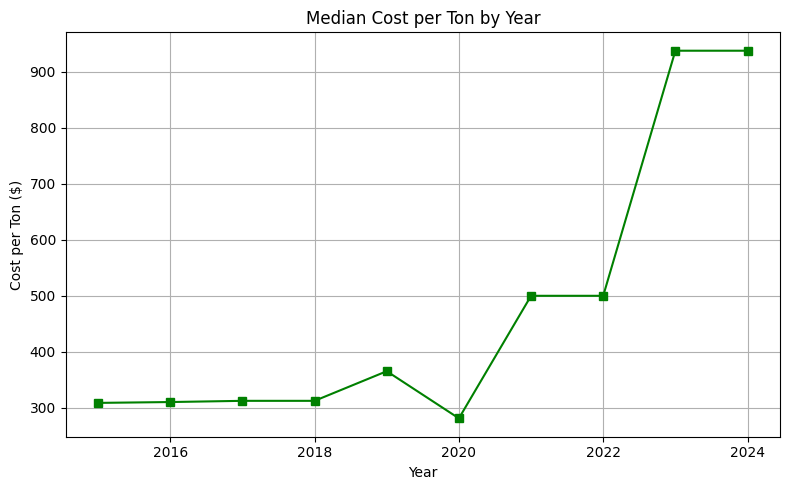

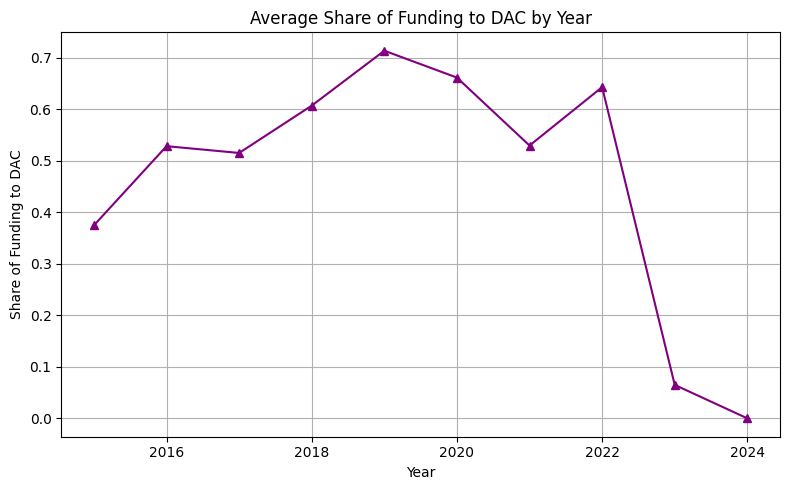

In [9]:

# Annual summary stats
annual_stats = df.groupby('Year').agg(
    avg_funding=('Total Program GGRFFunding', 'mean'),
    median_cost_per_ton=('cost_per_ton', 'median'),
    avg_share_DAC=('share_DAC', 'mean'),
    project_count=('cost_per_ton', 'count')
).dropna()

# Plot 1: Average Project Funding
plt.figure(figsize=(8, 5))
plt.plot(annual_stats.index, annual_stats['avg_funding'], marker='o')
plt.title('Average Project Funding by Year')
plt.xlabel('Year')
plt.ylabel('Average Funding ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Median Cost per Ton
plt.figure(figsize=(8, 5))
plt.plot(annual_stats.index, annual_stats['median_cost_per_ton'], marker='s', color='green')
plt.title('Median Cost per Ton by Year')
plt.xlabel('Year')
plt.ylabel('Cost per Ton ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Average Share of Funding to DAC
plt.figure(figsize=(8, 5))
plt.plot(annual_stats.index, annual_stats['avg_share_DAC'], marker='^', color='purple')
plt.title('Average Share of Funding to DAC by Year')
plt.xlabel('Year')
plt.ylabel('Share of Funding to DAC')
plt.grid(True)
plt.tight_layout()
plt.show()

Chart Captions

    Figure 1. Average Project Funding by Year (2015–2024)
    This figure displays the average dollar amount allocated per project under the CCI program annually. Funding levels increased significantly post-2020, indicating a potential shift in program scale or administrative strategy.

    Figure 2. Median Cost per Ton of GHG Reduction by Year (2015–2024)
    This figure illustrates changes in program efficiency over time, measured as the median cost per ton of greenhouse gas emissions reduced. Median costs rose steadily after 2020, suggesting potential diseconomies of scale or implementation challenges.

    Figure 3. Average Share of Funding to Disadvantaged Communities (DACs) by Year (2015–2024)
    This figure shows the average proportion of funding directed toward disadvantaged communities. While early years exceed statutory minimums, equity-focused allocations declined beginning in 2020, raising questions about evolving implementation priorities.
    

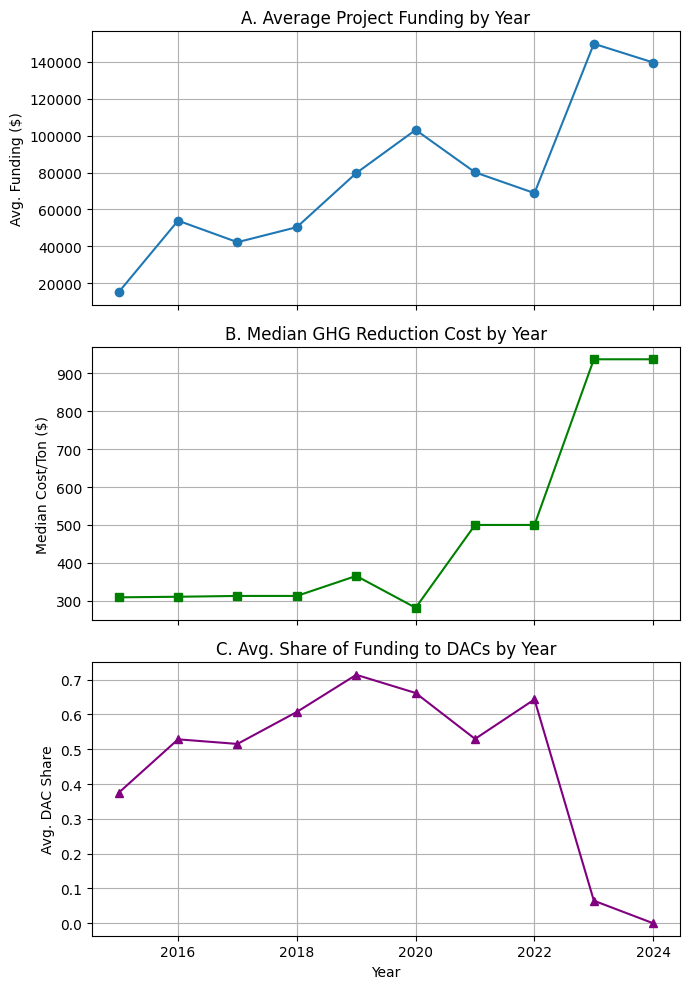

In [10]:

# Group by year
annual = df.groupby('Year').agg(
    avg_funding=('Total Program GGRFFunding', 'mean'),
    median_cost_per_ton=('cost_per_ton', 'median'),
    avg_share_DAC=('share_DAC', 'mean')
).dropna()

# Create the 3-panel figure
fig, axs = plt.subplots(3, 1, figsize=(7, 10), sharex=True)

# Panel 1: Average Funding
axs[0].plot(annual.index, annual['avg_funding'], marker='o')
axs[0].set_ylabel("Avg. Funding ($)")
axs[0].set_title("A. Average Project Funding by Year")
axs[0].grid(True)

# Panel 2: Median Cost per Ton
axs[1].plot(annual.index, annual['median_cost_per_ton'], marker='s', color='green')
axs[1].set_ylabel("Median Cost/Ton ($)")
axs[1].set_title("B. Median GHG Reduction Cost by Year")
axs[1].grid(True)

# Panel 3: Average DAC Share
axs[2].plot(annual.index, annual['avg_share_DAC'], marker='^', color='purple')
axs[2].set_ylabel("Avg. DAC Share")
axs[2].set_title("C. Avg. Share of Funding to DACs by Year")
axs[2].set_xlabel("Year")
axs[2].grid(True)

plt.tight_layout()
plt.savefig("cci_trends_3panel.png", dpi=300)  # For paper use
plt.show()


**Figure X. Annual Trends in Project Funding, Efficiency, and Equity Outcomes in California Climate Investments (2015–2024).**
This three-panel figure presents year-over-year trends in (A) average project funding, (B) median cost per ton of GHG reduced, and (C) average share of funding allocated to disadvantaged communities (DACs). The plots reveal a marked increase in funding levels beginning in 2020, accompanied by rising costs per ton and declining DAC benefit shares in later years. These shifts suggest potential programmatic or administrative inflection points, consistent with the hypothesis that external shocks have influenced the implementation and equity performance of the CCI program over time.

In [11]:
# Filter for the year 2020
df_2020 = df[df['Year'] == 2020]

# Find the project with the maximum funding in 2020
max_funding_project = df_2020[df_2020['Total Program GGRFFunding'] == 3328131]

# Display the project details
print(max_funding_project)

      Project ID Number Reporting Cycle Name  \
90114     19-20-D04-054                 2020   

                                   Agency_Name  \
90114  California Department of Transportation   

                                Program Name  \
90114  Low Carbon Transit Operations Program   

                            Sub Program Name Record Type  CensusTract  \
90114  Low Carbon Transit Operations Program   AWARD-IMP          NaN   

                      Lat Long Senate District Assembly District  ...  \
90114  37.784171, -122.408425;              11                17  ...   

      Date Operational  Project Completion Date  Is AB1550 Buffer Region  \
90114          1/21/23               2023-01-21                     True   

      Is Benefit DAC1550 Communities  Is Low Income Communities  cost_per_ton  \
90114                           True                       True     3328131.0   

       share_DAC log_funding                         Agency_Collapsed    Year  
90114        Na

### removign clean cars 4 all and clean vehicles

Correlation between mean and median (filtered): 0.95


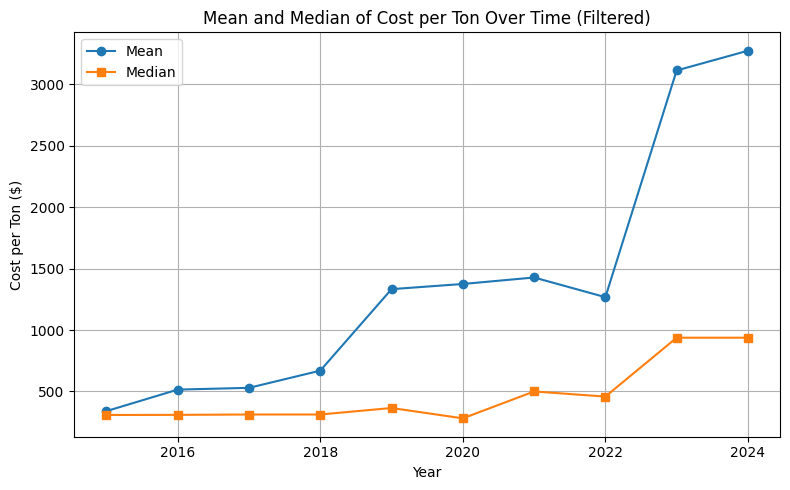

In [12]:
# Filter out rows where 'Sub Program Name' is 'Clean Cars 4 All' or 'Clean Vehicle'
df_filtered = df[~df['Sub Program Name'].isin(['Clean Cars 4 All', 'Clean Vehicle'])].copy()

# Proceed with the existing analyses using df_filtered
# Example: Recalculate derived variables
df_filtered['cost_per_ton'] = df_filtered['Total Program GGRFFunding'] / df_filtered['Total Project GHGReductions']
df_filtered['share_DAC'] = df_filtered['Total GGRFDisadvantaged Community Funding'] / df_filtered['Total Program GGRFFunding']
df_filtered['log_funding'] = np.log1p(df_filtered['Total Program GGRFFunding'])

# Continue with the rest of the analyses using df_filtered
# For example, rerun the correlation analysis:
stats_filtered = df_filtered.groupby('Year')['cost_per_ton'].agg(['mean', 'median']).dropna()
correlation_filtered = stats_filtered['mean'].corr(stats_filtered['median'])
print(f"Correlation between mean and median (filtered): {correlation_filtered:.2f}")

# Plot the filtered data
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(stats_filtered.index, stats_filtered['mean'], label='Mean', marker='o')
plt.plot(stats_filtered.index, stats_filtered['median'], label='Median', marker='s')
plt.title('Mean and Median of Cost per Ton Over Time (Filtered)')
plt.xlabel('Year')
plt.ylabel('Cost per Ton ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

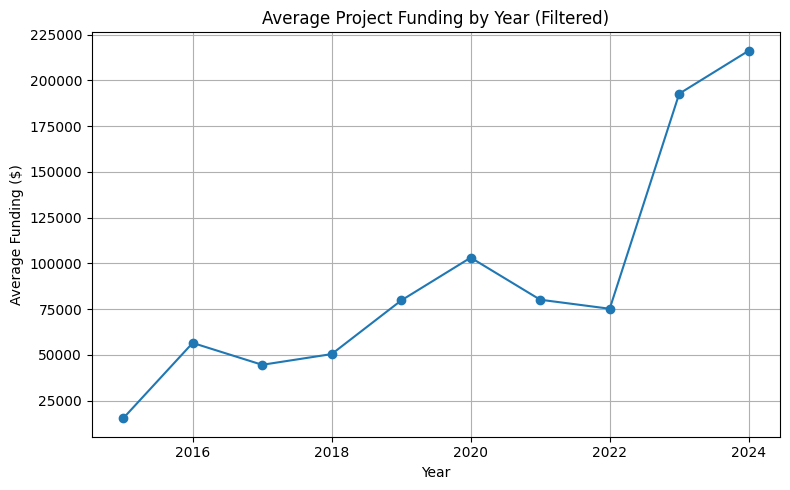

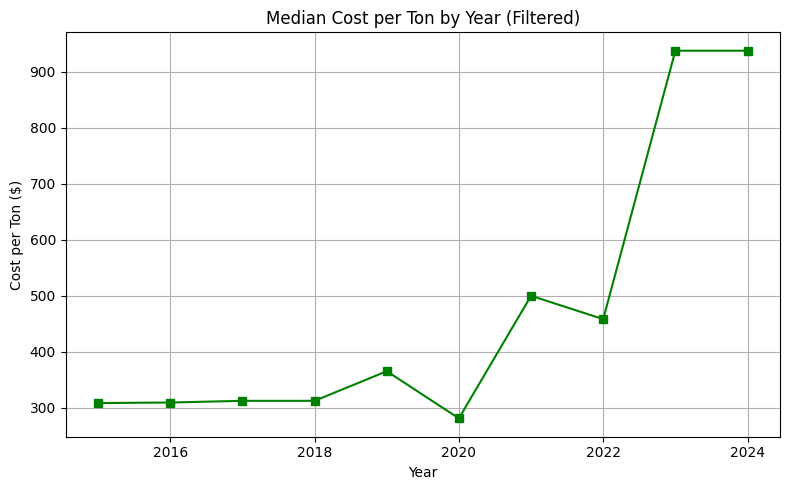

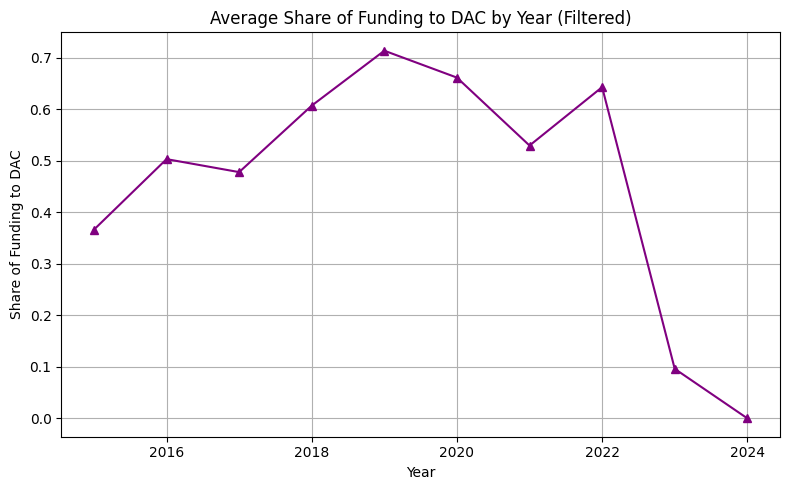

Correlation between mean and median (filtered): 0.95


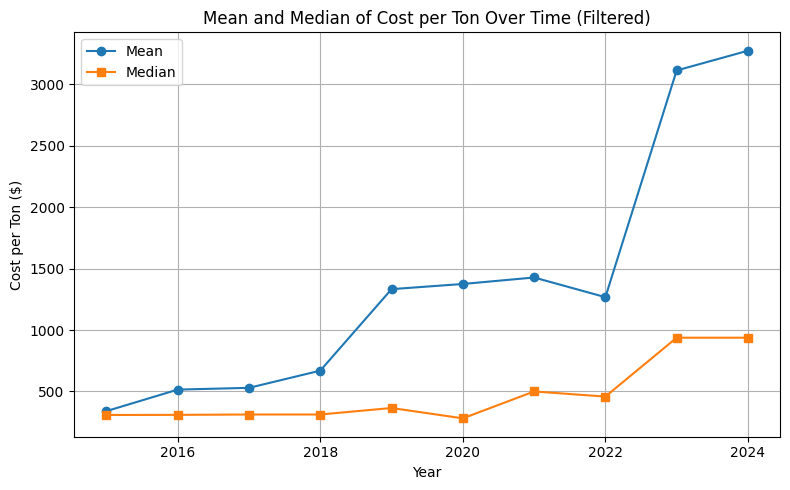

In [13]:
# Recalculate derived variables for df_filtered
df_filtered['cost_per_ton'] = df_filtered['Total Program GGRFFunding'] / df_filtered['Total Project GHGReductions']
df_filtered['share_DAC'] = df_filtered['Total GGRFDisadvantaged Community Funding'] / df_filtered['Total Program GGRFFunding']
df_filtered['log_funding'] = np.log1p(df_filtered['Total Program GGRFFunding'])

# Group by year and calculate summary statistics
annual_stats_filtered = df_filtered.groupby('Year').agg(
    avg_funding=('Total Program GGRFFunding', 'mean'),
    median_cost_per_ton=('cost_per_ton', 'median'),
    avg_share_DAC=('share_DAC', 'mean'),
    project_count=('cost_per_ton', 'count')
).dropna()

# Plot 1: Average Project Funding
plt.figure(figsize=(8, 5))
plt.plot(annual_stats_filtered.index, annual_stats_filtered['avg_funding'], marker='o')
plt.title('Average Project Funding by Year (Filtered)')
plt.xlabel('Year')
plt.ylabel('Average Funding ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Median Cost per Ton
plt.figure(figsize=(8, 5))
plt.plot(annual_stats_filtered.index, annual_stats_filtered['median_cost_per_ton'], marker='s', color='green')
plt.title('Median Cost per Ton by Year (Filtered)')
plt.xlabel('Year')
plt.ylabel('Cost per Ton ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Average Share of Funding to DAC
plt.figure(figsize=(8, 5))
plt.plot(annual_stats_filtered.index, annual_stats_filtered['avg_share_DAC'], marker='^', color='purple')
plt.title('Average Share of Funding to DAC by Year (Filtered)')
plt.xlabel('Year')
plt.ylabel('Share of Funding to DAC')
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation analysis
stats_filtered = df_filtered.groupby('Year')['cost_per_ton'].agg(['mean', 'median']).dropna()
correlation_filtered = stats_filtered['mean'].corr(stats_filtered['median'])
print(f"Correlation between mean and median (filtered): {correlation_filtered:.2f}")

# Plot mean vs. median over time (Filtered)
plt.figure(figsize=(8, 5))
plt.plot(stats_filtered.index, stats_filtered['mean'], label='Mean', marker='o')
plt.plot(stats_filtered.index, stats_filtered['median'], label='Median', marker='s')
plt.title('Mean and Median of Cost per Ton Over Time (Filtered)')
plt.xlabel('Year')
plt.ylabel('Cost per Ton ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()